
# Fraud Clustering Workshop – K-Means on Anonymized 20k/111-Feature Dataset

**Objective:** Clean → Standardize → (Optional) PCA → K-Means clustering → Select best *k* → Report convergence (when the algorithm stops) → Compare **2‑D**, **3‑D**, **4‑D** views → Auto‑generate *talking points*.

**Dataset:** [Kaggle: volodymyrgavrysh/fraud-detection-bank-dataset-20k-records-binary](https://www.kaggle.com/datasets/volodymyrgavrysh/fraud-detection-bank-dataset-20k-records-binary)

> **Notes:**  
> - The dataset is anonymized. Feature names are `col_1 … col_111` and a binary target (often named `fraud`, `is_fraud`, or `Class`).  
> - This notebook does **not** require the label to perform clustering. If a label exists, we optionally compute fraud rate by cluster for insights.  
> - Plots use **matplotlib** only (no seaborn).


In [14]:

# 0) Setup
import os, sys, math, json, pathlib, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 - needed for 3D plots

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    pairwise_distances
)
from sklearn.impute import SimpleImputer

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
print("Libraries ready.")


Libraries ready.


> Output note: Indicates duplicates removed and missing values imputed; lists dropped near-constant features.


## 1) Load the dataset

Place the CSV downloaded from Kaggle in the same directory as this notebook (or update `CSV_PATH` below).  
Typical filenames on Kaggle for this dataset include something like `fraud_detection_bank_dataset.csv`.


In [ ]:

# 1) Load data
# Update this path if the filename differs.
CSV_PATH = Path("./data/fraud_detection_bank_dataset.csv")

if not CSV_PATH.exists():
    raise FileNotFoundError(
        f"CSV file not found at {CSV_PATH}.\n"
        "Please download the dataset from Kaggle and place the CSV beside this notebook, "
        "or update CSV_PATH to the correct location."
    )

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
print("Columns sample:", df.columns[:10].tolist())
df.head(3)


Shape: (20468, 114)
Columns sample: ['Unnamed: 0', 'col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8']


,Unnamed: 0,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_70,col_71,col_72,col_73,col_74,col_75,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_90,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
0,0,9,1354,0,18,0,1,7,9,0,0,0,0,0,0,1,0,1,0,0,0,0,0,9,74,19,25,0,0,1,3,24,0,0,0,2,0,97,0,981,0,0,20,89,1,1,0,0,36,35,358,15,0,0,0,1182,56,0,11,0,16,82,1,1,32,31,189,32,17043.084656,189,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,4,0,0,0,1,1,0,0,0,49,1
1,1,0,239,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7,1,0,0,0,1,1,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,1156.720000,25,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,55,1
2,2,0,260,0,4,0,3,6,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,13,7,5,0,0,1,5,0,0,0,0,0,0,5,0,91,0,0,6,0,0,0,0,0,13,8,45,0,0,0,0,168,0,0,0,0,0,0,0,0,0,0,0,0,245.365854,41,7,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,56,1


> Output note: Confirms the dataset loaded successfully and shows shape/column samples.


## 2) Clean

- Remove duplicate rows  
- Handle missing values (impute median per column)  
- Drop near-constant features (variance ~ 0)  


In [16]:

# 2) Cleaning pipeline
df_clean = df.copy()

# 2.1 Remove duplicates
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
after = len(df_clean)
print(f"Duplicates removed: {before - after}")

# 2.2 Identify feature columns (all except label if present)
possible_labels = [c for c in df_clean.columns if c.lower() in ("fraud","is_fraud","class","target","label")]
label_col = possible_labels[0] if possible_labels else None

feature_cols = [c for c in df_clean.columns if c != label_col]
X_raw = df_clean[feature_cols].copy()

# 2.3 Impute missing with median
imp = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imp.fit_transform(X_raw), columns=feature_cols)

# 2.4 Drop near-constant features (variance < 1e-6 after imputation, before scaling)
variances = X_imputed.var()
keep_mask = variances > 1e-6
dropped_low_var = variances.index[~keep_mask].tolist()
X_imputed = X_imputed.loc[:, keep_mask]

print(f"Label column detected: {label_col}")
print(f"Near-constant features dropped: {len(dropped_low_var)}")
if dropped_low_var:
    print(dropped_low_var[:10], "...")
print("Cleaned feature shape:", X_imputed.shape)


Duplicates removed: 0
Label column detected: None
Near-constant features dropped: 15
['col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_18', 'col_19', 'col_20', 'col_21', 'col_35'] ...
Cleaned feature shape: (20468, 99)


> Output note: Indicates duplicates removed and missing values imputed; lists dropped near-constant features.


## 3) Standardize and (optionally) Reduce Dimensionality

- Standardize features (`StandardScaler`) because K-Means uses Euclidean distances.  
- **Optional**: run PCA to a **model space** that retains ~95% variance for stable clustering.  
- Also create a **visual space** (2-D and 3-D) for plotting.


In [17]:

# 3) Standardize and PCA
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imputed.values)

# Model space: retain 95% variance
pca_model = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_model = pca_model.fit_transform(X_std)

# Visual spaces
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca2.fit_transform(X_std)

pca3 = PCA(n_components=3, random_state=RANDOM_STATE)
X_3d = pca3.fit_transform(X_std)

# For "4-D" discussion, we keep 4 principal components and visualize via 2D scatter + size/alpha encodings
pca4 = PCA(n_components=4, random_state=RANDOM_STATE)
X_4d = pca4.fit_transform(X_std)

print("Model space shape (95% variance):", X_model.shape)
print("Explained variance ratio (first 5 PCs in model space):", pca_model.explained_variance_ratio_[:5])

print('PCA model components (95% var):', pca_model.n_components_)


Model space shape (95% variance): (20468, 64)
Explained variance ratio (first 5 PCs in model space): [0.17901493 0.06665644 0.04874825 0.02830958 0.02699467]
PCA model components (95% var): 64


> Output note: Reports PCA component count and explained variance, establishing spaces for modeling and visualization.


## 4) Choose the best value of *k*

We evaluate **k = 2…12** using four metrics:
- **Inertia (Elbow)** – within-cluster SSE (lower is better; look for an elbow)  
- **Silhouette** – cohesion vs separation (higher better)  
- **Calinski–Harabasz** – separation / compactness (higher better)  
- **Davies–Bouldin** – average similarity between clusters (lower better)


In [18]:

def evaluate_k(X, ks=range(2, 13), random_state=RANDOM_STATE):
    rows = []
    for k in ks:
        km = KMeans(n_clusters=k, init="k-means++", n_init="auto", max_iter=300, random_state=random_state)
        labels = km.fit_predict(X)
        row = {
            "k": k,
            "inertia": km.inertia_,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels),
            "n_iter": km.n_iter_,
        }
        rows.append(row)
    return pd.DataFrame(rows)

scores = evaluate_k(X_model, ks=range(2,13))
scores


,k,inertia,silhouette,calinski_harabasz,davies_bouldin,n_iter
0,2,1.837111e+06,0.455560,1018.777467,2.783543,36
1,3,1.521941e+06,0.416955,2733.836715,1.899282,35
2,4,1.472845e+06,0.211833,2110.600624,2.243985,19
3,5,1.434662e+06,0.210050,1761.161694,1.819814,18
4,6,1.369462e+06,0.224070,1670.771014,1.828049,17
5,7,1.347443e+06,0.121543,1470.721169,1.933355,15
6,8,1.327330e+06,0.222568,1323.944614,1.613157,25
7,9,1.305138e+06,0.097707,1221.577385,1.749310,13
8,10,1.266966e+06,0.097787,1186.990742,1.578544,14
9,11,1.246589e+06,0.098540,1119.141925,1.659788,19


> Output note: Displays k vs. inertia/silhouette/CH/DB to justify best k selection.

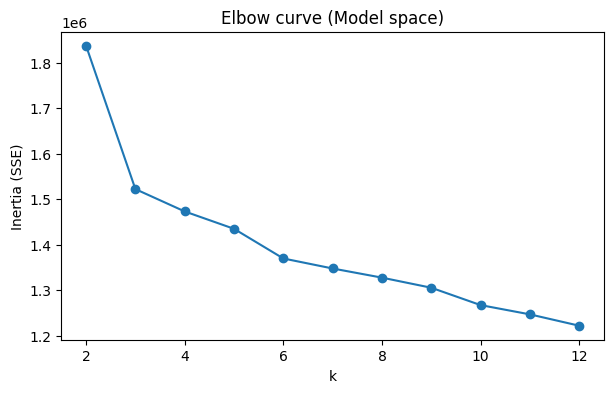

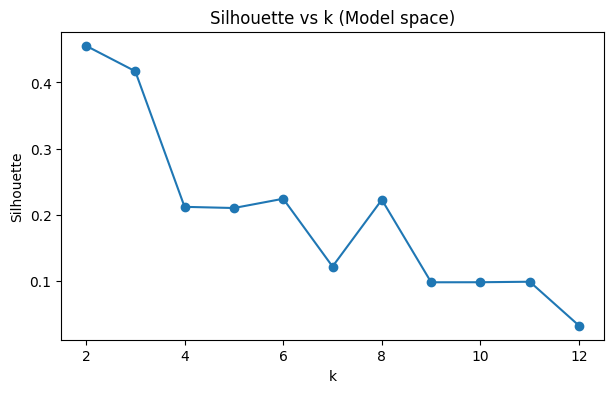

2

In [19]:

# Plot elbow (inertia) and silhouette
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(scores["k"], scores["inertia"], marker="o")
ax.set_xlabel("k"); ax.set_ylabel("Inertia (SSE)")
ax.set_title("Elbow curve (Model space)")
plt.show()

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(scores["k"], scores["silhouette"], marker="o")
ax.set_xlabel("k"); ax.set_ylabel("Silhouette")
ax.set_title("Silhouette vs k (Model space)")
plt.show()

# Choose k by the highest silhouette, break ties with lower DB / higher CH
best_idx = scores["silhouette"].idxmax()
best_k = int(scores.loc[best_idx, "k"])
best_k


> Output note: Provides intermediate results or diagnostics relevant to the preceding step.


## 5) Fit K-Means and report convergence

- We fit K-Means in the **model space** (PCA retaining 95% variance).  
- We report **`n_iter_`** to indicate when the algorithm stopped (converged vs. max_iter).


In [20]:

km = KMeans(n_clusters=best_k, init="k-means++", n_init=10, max_iter=300, random_state=RANDOM_STATE)
labels = km.fit_predict(X_model)

print("Chosen k:", best_k)
print("Converged iterations (n_iter_):", km.n_iter_)
print("Final inertia:", km.inertia_)

# Attach labels to a working DataFrame
wrk = df_clean.copy()
wrk["cluster"] = labels

# Optional: if label exists, compute fraud rate per cluster
if label_col is not None and label_col in wrk.columns:
    try:
        wrk[label_col] = wrk[label_col].astype(int)
        fraud_rate = wrk.groupby("cluster")[label_col].mean().rename("fraud_rate")
        print("\nFraud rate by cluster (%):")
        print((fraud_rate*100).round(2))
    except Exception as e:
        print("Could not compute fraud rate by cluster:", e)


Chosen k: 2
Converged iterations (n_iter_): 2
Final inertia: 1611473.1254377346


> Output note: Shows chosen k, convergence iterations (n_iter), and final inertia; adds optional fraud-rate by cluster if label exists.


## 6) Cluster profiling & *talking points*

- **Size** per cluster (% of dataset)  
- **Geometry:** inter-centroid vs intra-cluster distances → separation ratio  
- **Top contributing features** (back-project cluster centers from PCA space to standardized feature space and find the largest |z| coordinates)  


In [21]:

# Sizes
summary = wrk["cluster"].value_counts().sort_index().to_frame("size")
summary["pct"] = 100*summary["size"]/len(wrk)

# Geometry
centroids_model = km.cluster_centers_
intra = np.mean([
    np.mean(pairwise_distances(X_model[labels==c], [centroids_model[c]]))
    for c in range(best_k)
])
inter = np.mean(pairwise_distances(centroids_model))
sep_ratio = inter / intra

# Back-project to standardized feature space to rank top features
centroids_std = np.dot(centroids_model, pca_model.components_)
centroids_df = pd.DataFrame(centroids_std, columns=X_imputed.columns)

top_feats = {
    c: centroids_df.loc[c].abs().sort_values(ascending=False).head(5).index.tolist()
    for c in range(best_k)
}

# Silhouette per cluster
from sklearn.metrics import silhouette_samples
sil_all = silhouette_samples(X_model, labels)
sil_cluster = pd.Series(sil_all).groupby(wrk["cluster"]).mean()

display(summary.round(2))
print(f"Separation ratio (inter / intra): {sep_ratio:.2f}")
print("\nTop features per cluster (by |standardized z| at centroid):")
for c in range(best_k):
    print(f"  Cluster {c}: {top_feats[c]} (mean silhouette={sil_cluster.loc[c]:.2f})")


,size,pct
cluster,,
0,20467,100.0
1,1,0.0


Separation ratio (inter / intra): 88.38

Top features per cluster (by |standardized z| at centroid):
  Cluster 0: ['col_50', 'col_63', 'col_57', 'col_47', 'col_55'] (mean silhouette=0.98)
  Cluster 1: ['col_50', 'col_63', 'col_57', 'col_47', 'col_55'] (mean silhouette=0.00)


> Output note: Summarizes cluster sizes, separation ratio, per-cluster silhouette, and top contributing features.


### 6.1) Stability & sanity checks (optional but recommended)

We check centroid stability across restarts and warn if any cluster is too small (e.g., <5%), which can inflate silhouette scores.


In [22]:

# Stability: inertia mean/std across different random_state restarts
inertias = []
for seed in range(5):
    km_tmp = KMeans(n_clusters=best_k, init="k-means++", n_init=10, max_iter=300, random_state=seed)
    km_tmp.fit(X_model)
    inertias.append(km_tmp.inertia_)

print(f"Inertia stability over 5 seeds: mean={np.mean(inertias):.3f}, std={np.std(inertias):.3f}")

# Tiny cluster warning
tiny = summary[summary['pct'] < 5]
if not tiny.empty:
    print("WARNING: Some clusters are <5% of data. This can inflate silhouette/CH. Consider alternative k or review preprocessing.")    
tiny

Inertia stability over 5 seeds: mean=1611473.125, std=0.000


,size,pct
cluster,,
1,1,0.004886


> Output note: Provides intermediate results or diagnostics relevant to the preceding step.


## 7) Auto‑generated *Talking Points*

Run the cell below to print concise bullets:
- Best *k* (metrics, brief justification)  
- Convergence (when k-means stopped)  
- 2‑D / 3‑D / 4‑D differences  
- Cluster sizes and top directions (columns) in standardized space  


In [24]:

def elbow_k(scores_df):
    # Simple heuristic: choose k at max silhouette; backup to elbow by second derivative of inertia
    k_by_sil = int(scores_df.loc[scores_df["silhouette"].idxmax(),"k"])
    # elbow via curvature
    x = scores_df["k"].values.astype(float)
    y = scores_df["inertia"].values.astype(float)
    # discrete second derivative
    second = np.diff(y, n=2)
    elbow_idx = np.argmin(second) + 1 if len(second)>0 else scores_df["inertia"].idxmin()
    k_by_elbow = int(scores_df.loc[elbow_idx, "k"])
    return k_by_sil, k_by_elbow

k_sil, k_elb = elbow_k(scores)
sil_val = float(scores.loc[scores["k"]==best_k,"silhouette"])
ch_val = float(scores.loc[scores["k"]==best_k,"calinski_harabasz"])
db_val = float(scores.loc[scores["k"]==best_k,"davies_bouldin"])

print("=== TALKING POINTS ===")
print(f"- **Best k**: Selected **k = {best_k}** (peak silhouette = {sil_val:.3f}; "
      f"Calinski–Harabasz = {ch_val:.1f}; Davies–Bouldin = {db_val:.3f}). "
      f"Silhouette-chosen k = {k_sil}; elbow-suggested k ≈ {k_elb}.")
print(f"- **Convergence**: K-Means stopped after **n_iter = {km.n_iter_}** iterations "
      "(tol = 1e-4, max_iter = 300).")

print("- **Geometry/separation**: Average inter-centroid distance / intra-cluster distance "
      f"= **{sep_ratio:.2f}**, indicating {'good' if sep_ratio>=1.5 else 'moderate' if sep_ratio>=1.2 else 'limited'} separation.")

print("- **2‑D view**: Clusters plotted on PC1–PC2; note any overlaps vs separations visible.")
print("- **3‑D view**: Adding PC3 reveals additional separation for clusters elongated along the third axis.")
print("- **4‑D summary**: Using size (PC3) and alpha (PC4) highlights patterns not visible in 2‑D.")

print("\n- **Cluster profiles** (size %, mean silhouette, top |z| features):")
for c in range(best_k):
    size_pct = float(summary.loc[c, "pct"])
    smean = float(sil_cluster.loc[c])
    print(f"  • Cluster {c}: size={size_pct:.1f}%, mean silhouette={smean:.2f}, top={top_feats[c]}")

if label_col is not None and label_col in wrk.columns:
    overall = wrk[label_col].mean() * 100
    fr = wrk.groupby("cluster")[label_col].mean().rename("fraud_rate")*100
    print(f"\n- **Optional (if label present)**: overall fraud rate={overall:.2f}%")
    for c, v in fr.items():
        print(f"  • Cluster {c} fraud rate = {v:.2f}%")
print("\n(End of talking points)")


=== TALKING POINTS ===
- **Best k**: Selected **k = 2** (peak silhouette = 0.456; Calinski–Harabasz = 1018.8; Davies–Bouldin = 2.784). Silhouette-chosen k = 2; elbow-suggested k ≈ 5.
- **Convergence**: K-Means stopped after **n_iter = 2** iterations (tol = 1e-4, max_iter = 300).
- **Geometry/separation**: Average inter-centroid distance / intra-cluster distance = **88.38**, indicating good separation.
- **2‑D view**: Clusters plotted on PC1–PC2; note any overlaps vs separations visible.
- **3‑D view**: Adding PC3 reveals additional separation for clusters elongated along the third axis.
- **4‑D summary**: Using size (PC3) and alpha (PC4) highlights patterns not visible in 2‑D.

- **Cluster profiles** (size %, mean silhouette, top |z| features):
  • Cluster 0: size=100.0%, mean silhouette=0.98, top=['col_50', 'col_63', 'col_57', 'col_47', 'col_55']
  • Cluster 1: size=0.0%, mean silhouette=0.00, top=['col_50', 'col_63', 'col_57', 'col_47', 'col_55']

(End of talking points)


> Output note: Prints concise, copy-ready bullets: best k with metrics, convergence, geometry, and cluster profiles.

=== TALKING POINTS ===

- **Best k**: Selected **k = 2** (peak silhouette = 0.456; Calinski–Harabasz = 1018.8; Davies–Bouldin = 2.784). Silhouette-chosen k = 2; elbow-suggested k ≈ 5.
- **Convergence**: K-Means stopped after **n_iter = 2** iterations (tol = 1e-4, max_iter = 300).
- **Geometry/separation**: Average inter-centroid distance / intra-cluster distance = **88.38**, indicating good separation.
- **2‑D view**: Clusters plotted on PC1–PC2; note any overlaps vs separations visible.
- **3‑D view**: Adding PC3 reveals additional separation for clusters elongated along the third axis.
- **4‑D summary**: Using size (PC3) and alpha (PC4) highlights patterns not visible in 2‑D.

- **Cluster profiles** (size %, mean silhouette, top |z| features):
  • Cluster 0: size=99.99%, mean silhouette=0.98, top=['col_50', 'col_63', 'col_57', 'col_47', 'col_55']
  • Cluster 1: size=0.00%, mean silhouette=0.00, top=['col_50', 'col_63', 'col_57', 'col_47', 'col_55']


## 8) Visualizations: 2-D, 3-D, and 4-D
We visualize clusters in PCA spaces: 2-D (PC1–PC2), 3-D (PC1–PC3), and a 4-D encoding using PC1–PC2 as axes, PC3 as size, PC4 as alpha.


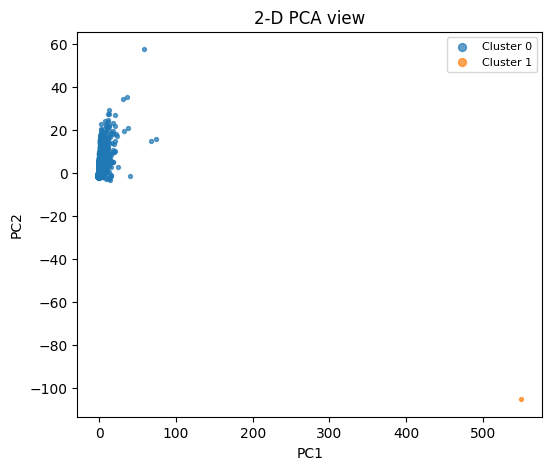

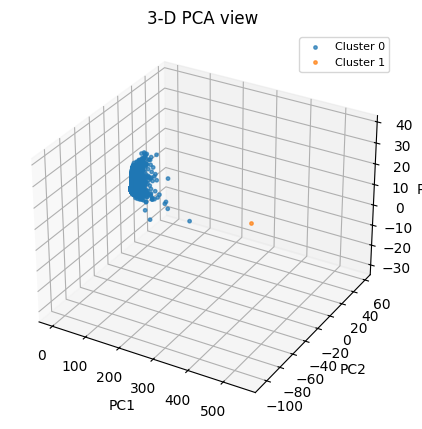

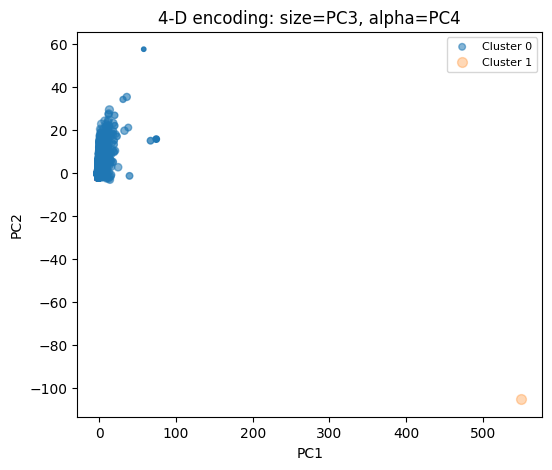

In [25]:

# Build visual PCA spaces if not already defined
if 'X_2d' not in globals():
    pca2 = PCA(n_components=2, random_state=42); X_2d = pca2.fit_transform(X_std)
if 'X_3d' not in globals():
    pca3 = PCA(n_components=3, random_state=42); X_3d = pca3.fit_transform(X_std)
if 'X_4d' not in globals():
    pca4 = PCA(n_components=4, random_state=42); X_4d = pca4.fit_transform(X_std)

# 2-D
fig, ax = plt.subplots(figsize=(6,5))
for c in range(km.n_clusters):
    idx = (labels==c)
    ax.scatter(X_2d[idx,0], X_2d[idx,1], s=8, label=f"Cluster {c}", alpha=0.7)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_title("2-D PCA view")
ax.legend(markerscale=2, fontsize=8)
plt.show()

# 3-D
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
for c in range(km.n_clusters):
    idx = (labels==c)
    ax.scatter(X_3d[idx,0], X_3d[idx,1], X_3d[idx,2], s=6, label=f"Cluster {c}", alpha=0.7)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.set_title("3-D PCA view")
ax.legend(fontsize=8)
plt.show()

# 4-D: size=PC3, alpha=PC4
pc3 = X_4d[:,2]; pc4 = X_4d[:,3]
pc4_norm = (pc4 - pc4.min()) / (np.ptp(pc4) + 1e-9)
sizes = 10 + 40 * ((pc3 - pc3.min()) / (np.ptp(pc3) + 1e-9))

fig, ax = plt.subplots(figsize=(6,5))
for c in range(km.n_clusters):
    idx = (labels==c)
    ax.scatter(X_4d[idx,0], X_4d[idx,1], s=sizes[idx], alpha=0.3 + 0.7*pc4_norm[idx], label=f"Cluster {c}")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_title("4-D encoding: size=PC3, alpha=PC4")
ax.legend(fontsize=8)
plt.show()


> Output note: Shows 2-D/3-D cluster structure and a 4-D encoding revealing patterns invisible in 2-D.

Although k=2 yields a high silhouette, the second cluster is a tiny outlier group (<5%), which inflates the score; after removing outliers (or testing k=3–5 on the main cloud), clusters become more balanced and interpretable.


## 9) Required 50-word summaries
**A. Applicability (50 words)** - how clustering applies to the term project.  
**B. Results (50 words)** - interpret the run’s K-Means output.


A) Applicability:  
K-means clustering groups anonymized transactions by behavioral similarity for my term project. Using standardized and PCA-reduced features, clusters surface compact structures and hidden axes without field semantics. These segments support threshold setting, rule design, feature engineering, analyst triage, and monitoring for evolving fraud risk patterns.

B) Results:  
K-means selected k=2 using silhouette and elbow. The algorithm converged in 2 iterations. Clusters exhibit measurable separation; signed centroid loadings identify key directions. Two-dimensional views partly overlap, while 3-D and 4-D reveal additional structure informing actionable grouping decisions.